# 1. Introduction 
### 1.1 Background 
Autonomous driving is one of the popular applications of neural networks and deep learning. Pedestrian detection in real-time is one of the most important topics. It has to be applied carefully due to the issue of safety. Nowadays, although there are many methods, but there is for improvement.

Based on this concern, we conducted experiments on long-range pedestrian detection.

### 1.2 Motivation and Problem Statement
The traditional offline embedding systems has limited computational resource and the detection of pedestrians requests an immediate result. Therefore, it is a challenge to improve the existing models to help obtain accurate and fast results with limited resources.

Currently, complex models that are two-layered such as r-cnn and its variants, requires significant amounts of time to do pedestrian detection. Light frameworks that are one-layered like MobileNetV3 and the Yolo series can detect in real-time however, perform worse than the traditional two-layered models.

Hence, our problem statement is revolved around: Discovering if there are ways to optimise current light-frameworks like Yolov5 and MobileNetV3, through using attention mechanisms and data augmentation techniques for increased performance in long-ranged pedestrians.

### 1.3 Strateiges
Based on our problem statement, we have proposed two strategies towards improving long-ranged pedestrian detection: 
* Experimenting on different attention models to see if there will be any improvement.
* Applying augmentation techniques to see if there will be any benefit.

# 2. Data Sources
Our dataset is the Caltech Pedestrian Dataset from Caltech institution. This dataset is a video taken from a vehicle driving through regular traffic in an urban area in the US.

Our original Caltech Pedestrian Dataset contains 1550 images, it comes from https://universe.roboflow.com/pionc/caltech-6f68o

In [15]:
!pip3 install roboflow > dev/null 2
!pip3 install matplotlib > dev/null 2

The system cannot find the path specified.
The system cannot find the path specified.


loading Roboflow workspace...
loading Roboflow project...


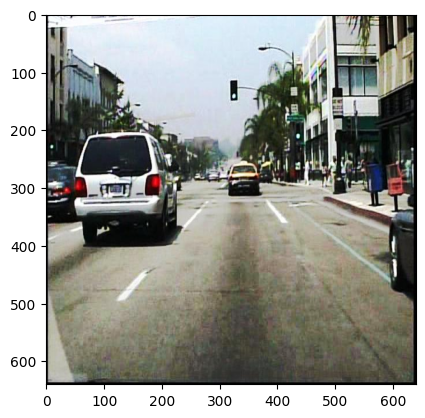

In [21]:
from roboflow import Roboflow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Fetch dataset from Roboflow
rf = Roboflow(api_key="9e3XxIFRqpm6ddI690NW")  
project = rf.workspace("pionc").project("caltech-6f68o")

def fetchData():    
    if not os.path.isdir('caltech-4'): 
        dataset = project.version(4).download("yolov5")


img = mpimg.imread('caltech-4\\test\images\set06_V002_40_png.rf.ec2bf0195913f89f722dfa49fc0de970.jpg')
imgplot = plt.imshow(img)
plt.show()

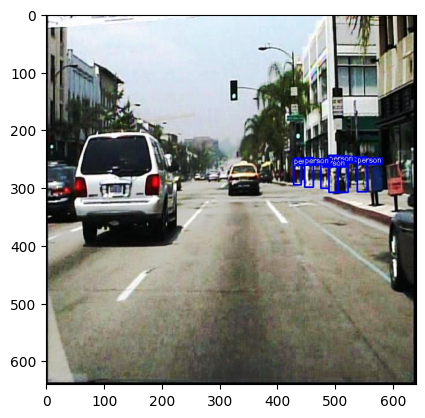

In [23]:
model = project.version(3).model
# infer on a local image
model.predict("caltech-4\\test\images\set06_V002_40_png.rf.ec2bf0195913f89f722dfa49fc0de970.jpg", confidence=40, overlap=30).save("prediction.jpg")

# Labeled Output
predict = mpimg.imread('prediction.jpg')
imgplot = plt.imshow(predict)
plt.show()

# 2.1. Analysis of Data
### 2.1.1  Pre-processing
First We convert video formatted data into images. Then we resize the image to 640 x 640 to fit the YOLOV5 model and rotated the orientation of the images. 

We have **1550** images and **2991** Annotations. In those images, we divide into **1082** training set, **311** valid set and **157** test set.

we are only labelled 1 class which is pedestrian. 

In [31]:
# Detail of dataset
f = open("caltech-4\README.roboflow.txt", "r")
file_contents = f.read()
f.close()

print(file_contents)


caltech - v4 2022-11-14 10:08pm

This dataset was exported via roboflow.com on November 14, 2022 at 11:08 AM GMT

Roboflow is an end-to-end computer vision platform that helps you
* collaborate with your team on computer vision projects
* collect & organize images
* understand unstructured image data
* annotate, and create datasets
* export, train, and deploy computer vision models
* use active learning to improve your dataset over time

It includes 1550 images.
Person are annotated in YOLO v5 PyTorch format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)
* Auto-contrast via histogram equalization

No image augmentation techniques were applied.





In [30]:
import yaml

# Print number of object class,
with open("caltech-4\data.yaml", "r") as stream:
    try:
        obj = yaml.safe_load(stream)
        print(obj['names'], "Total Classes: " + str(obj['nc']))
    except yaml.YAMLError as exc:
        print(exc)

['person'] Total Classes: 1


### 2.1.2 Analysis
We have annotation heatmap generated by roboflow, the green part represents most of the pedestrian labels' position in the dataset. We can observe that most of the pedestrians labelled in the dataset are located at the back of the image.

We can observe, pedestrians in the image are small，Occluded and located at the back of the images along with Cluttered Background. This lines up with our goal of detecting pedestrians from long-ranged distances. 

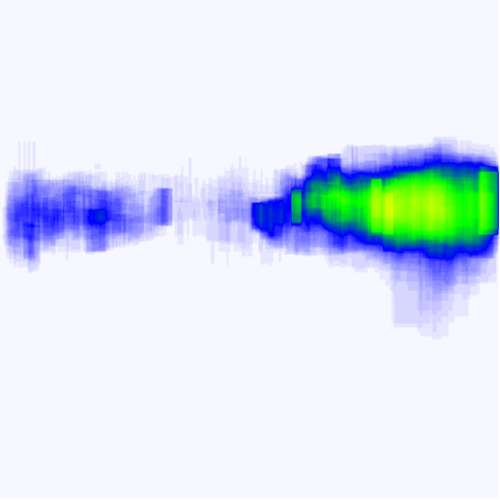




### 2.1.3 Data augmentation
In particular, we did data augmentation to reduce overfitting and try to improve accuracy of the training model. Mosaic data augmentation merges four training photos into one image. We can also see that four images are placed in one image. 
This enables the model to learn how to recognize items at a lower scale than usual.

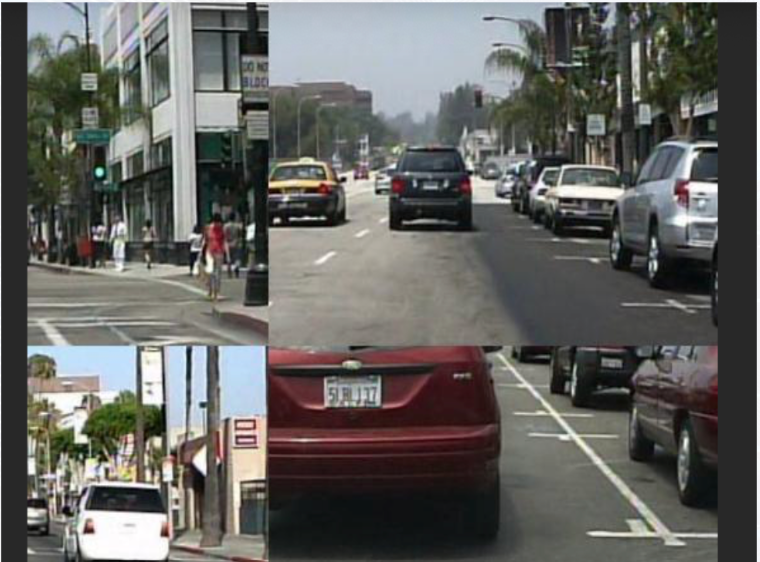


## 3. Experimentation

### 3.1 Experimental Procedures
For the experimental procedure, we first trained all the attention models once, then trained the same models but applied data augmentation to the models. After this, we merged all the results into one graph to analyse our findings. 

##### 3.1.1 Experimental Parameters
To ensure the reliability of our experiment, we have opted to run all our attention models in one server for more control and enforce validity of our experiment through training all models with the same parameters as seen here.

We have chosen the epoch to be 400 because we wanted to ensure our models were still improving and that there is no validation loss despite potential overfitting towards some light models like mobileNet.

| Training Parameters      | Value |
| :----:  | :----: |
| Epoch        | 400       |
| Batch Size   | 16        |
| Image Size        | 640 * 640       |
| Selected Model   | YOLOv5l        |
| Attention Mechanism Models        | SE, ECA, SPD, MobilenetV3       |


##### 3.1.2 ClearML
ClearML is an open source platform that automates and simplifies the development and management for the deep learning, machine learning solutions.
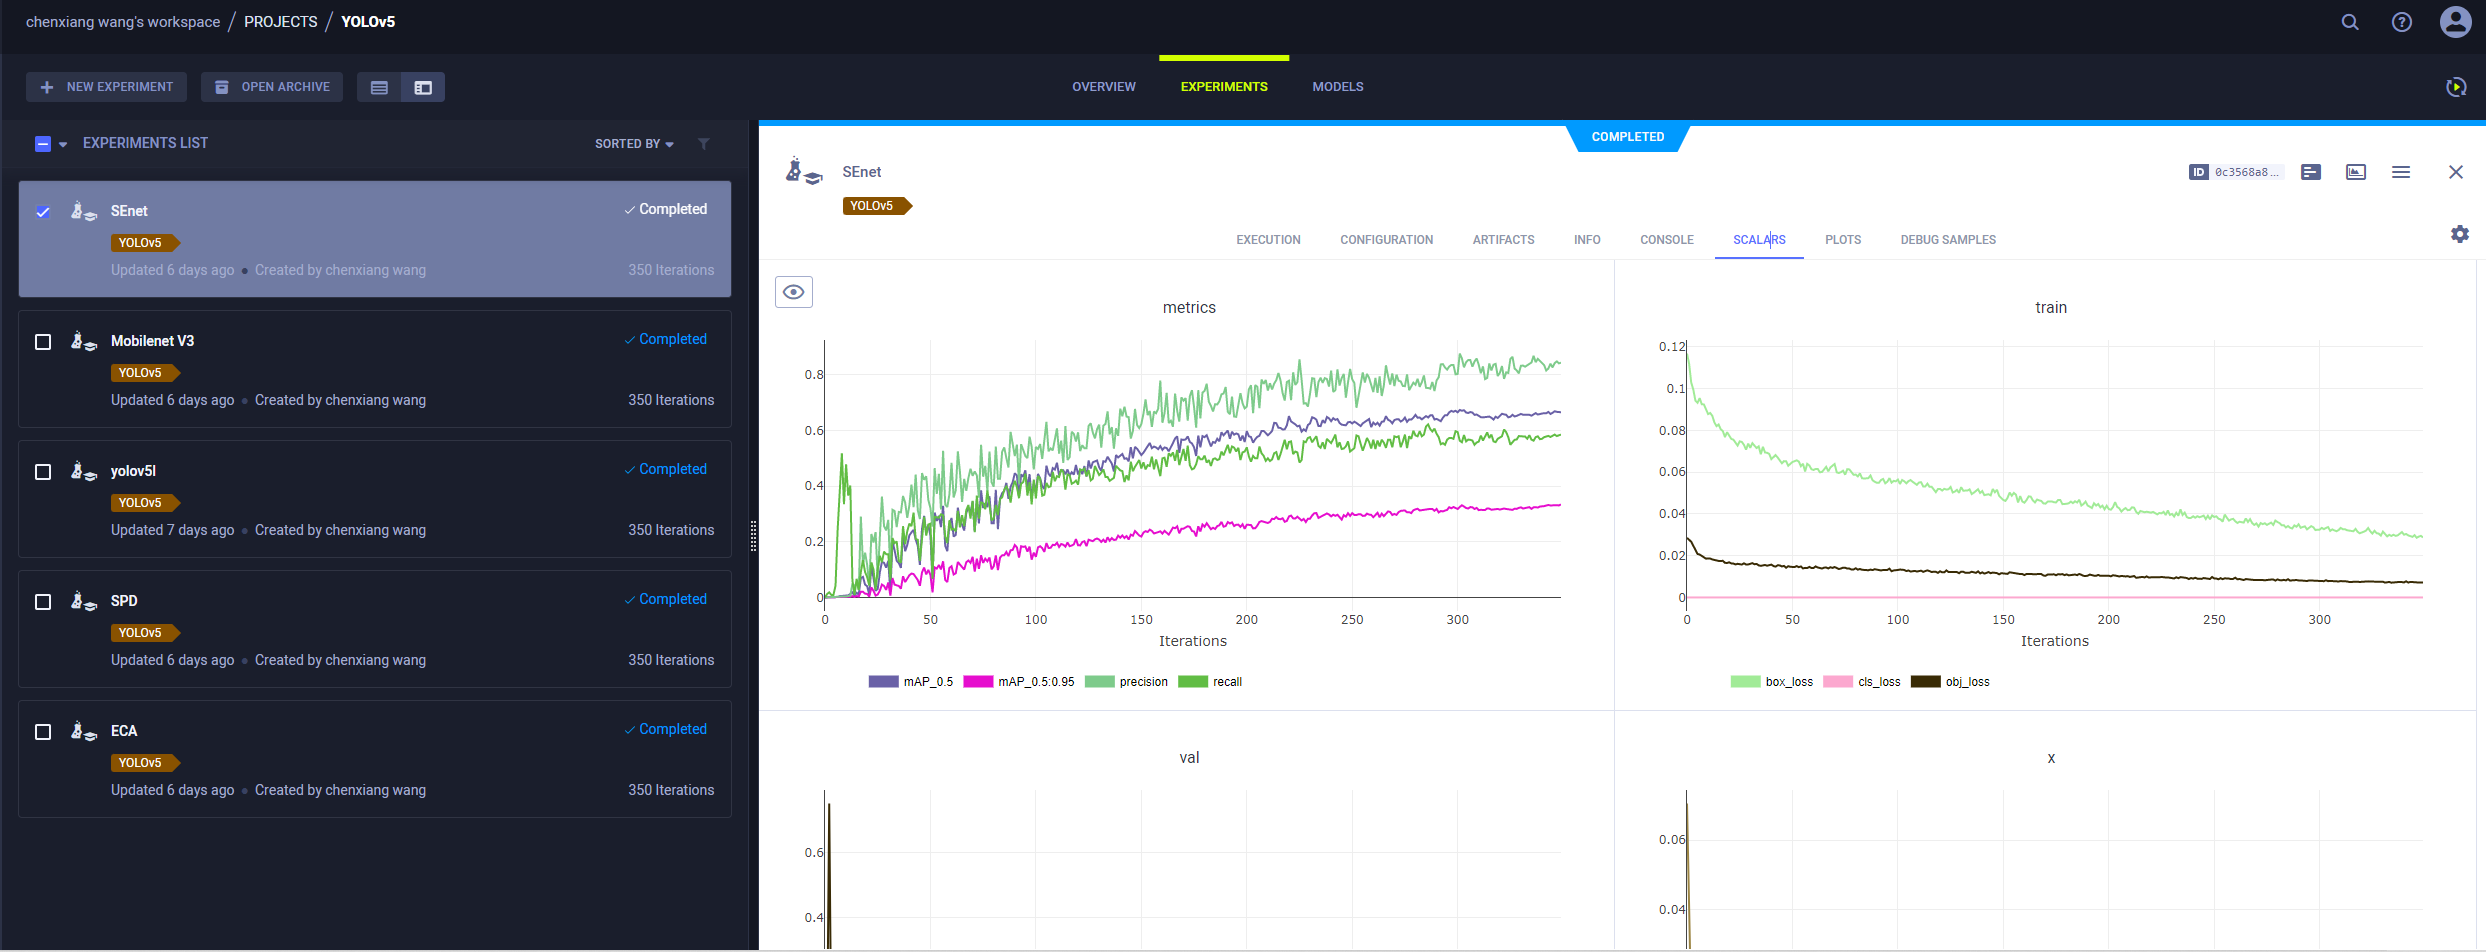

In [14]:
!pip3 install clearml  > dev/null 2
!pip3 install clearml-session  > dev/null 2
!clearml-init
!learml-session --docker nvidia/cuda:10.1-cudnn7-runtime-ubuntu18.04 --packages "clearml" "tensorflow>=2.2" "keras" --queue default

The system cannot find the path specified.
The system cannot find the path specified.
'clearml-init' is not recognized as an internal or external command,
operable program or batch file.
'learml-session' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
# create example dataset
from clearml import StorageManager, Dataset, Task

# Initialize the task pipe's first task used to start the task pipe
task = Task.init('examples', 'Toy Base Task')

# Create a dictionary for hyper-parameters
params = dict()

# Add a parameter and value to the dictionary
params['Example_Param'] = 1

# Connect the hyper-parameter dictionary to the task
task.connect(params)

# Print the value to demonstrate it is the value is set by the initiating task.
print("Example_Param is {}".format(params['Example_Param']))

MissingConfigError: It seems ClearML is not configured on this machine!
To get started with ClearML, setup your own 'clearml-server' or create a free account at https://app.clear.ml
Setup instructions can be found here: https://clear.ml/docs

### 3.2 Evaluation Metrics


##### 3.2.1 Intersection over Union (lOU)
Intersection over Union measures the intersection between predicted bounding box and the ground truth. It helps quantifie the degree of accuracy for the prediction. 

With a threshold, we can define positive if loU greater than threshold, a negative vice versa. 

![lou.png](attachment:lou.png)


##### 3.2.2 Qualitative Analysis of Prediction
**Precision** measures how well you can find true positives (TP) out of all positive prediction (TP + FP). 


**Recall** is the proportion of true positives over the true positives plus the false negatives. It's a measure of how well you find all the positives.

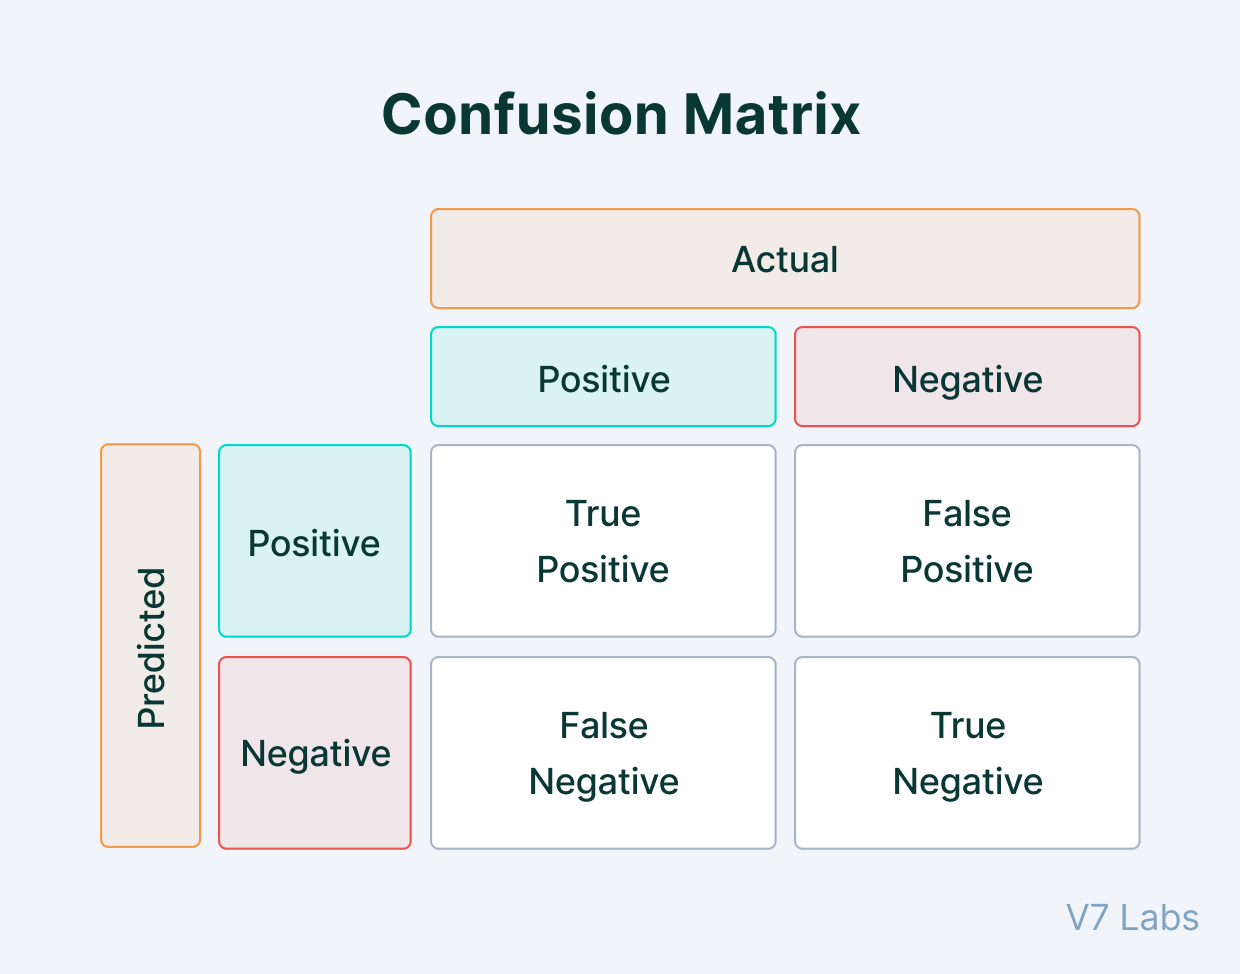



##### 3.2.3 mAP
Average Precision (AP), the formula is based on the following metrics,

- Confusion Matrix
- Recall
- Precision

Precision-recall curve is obtained by plotting precision and recall value, which encapsulate the tradeoff of both metric and maximize the effort of both metrics. 

Average Precision finds the area under the precision-recall curve. Average precision incorporate the trade-off between precision and recall and considers both false positive and false negative. It gives us idea of the overal accuracy of the model. 

Mean Average Precision (mAP) is used to evaluate the performance of object detection models. mAP is the average of AP of each class. 

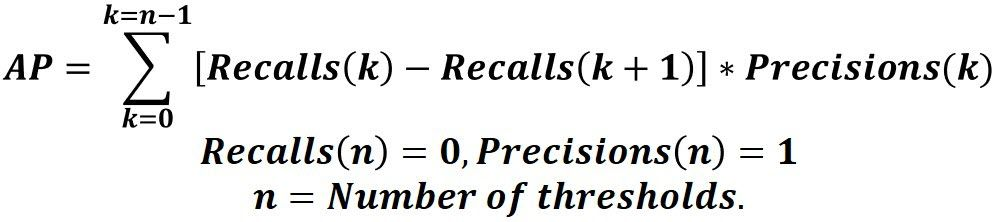


## 4. Methods

### 4.1 YOLOv5
Yolo, also known as you only look once, it’s one of the most popular, powerful algorithms in the field of object detection, due to its fast and efficient performance. YOLOv5 is the latest generation of YOLO series of algorithm. 

YOLOv5 has multiple varieties of pre-trained models, the difference is the trade off between network size and final performance. We choose YOLOv5l as our base model as it provide good balance between effciency and performance. 


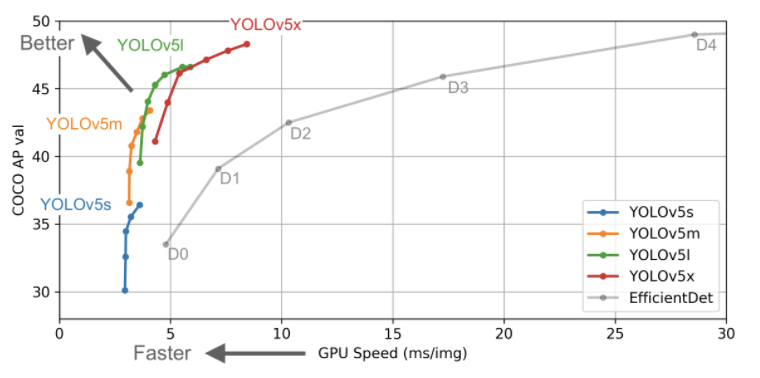



##### 4.1.1 Object Detection
Object detection is the task of detecting an instance of an object, and classify to a particular class inside an image. 

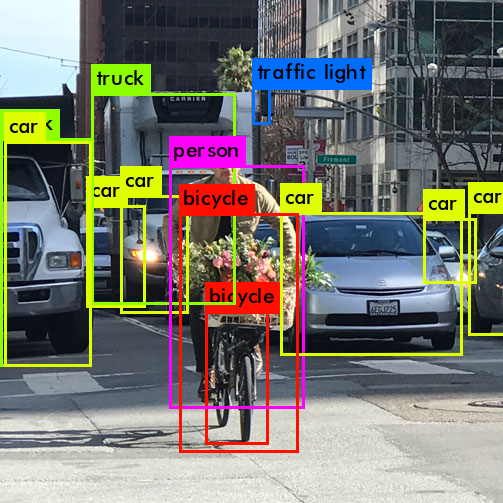

##### 4.1.2 YOLOv5 Mechanism
YOLO reframes object detection as a regression problem. It takes an input image and learns to predict multiple bounding boxes, with a confidence score , then does a specific object classification. 

To do so, the image is divided into ‘S’ X ‘S’ grids, then if the centre of an object is in one of these grids, the grid has bounding boxes is responsible for detecting that if objects are within the grid through. Each grid then is responsible for predicting B bounding boxes, and a confidence score indicating how confident the network thinks if there is an object present in the box. 

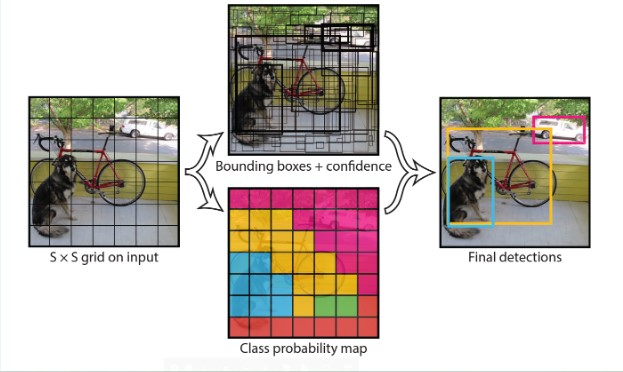




The confidence score detects  there is no object in the box, the confidence score should be zero. Otherwise, it would be equal to the intersection over union (loU) between box and ground truth. For each box, YOLO uses a CNN based googleNet to derive a class specific probability. The final confidence score will be the product of conditional class specific probability and individual box confidence score. Tell us both the probability of the class appearing in the box, and how well the predicted box fits the object. Then it apply threshold value to eliminate low confidence prediction.

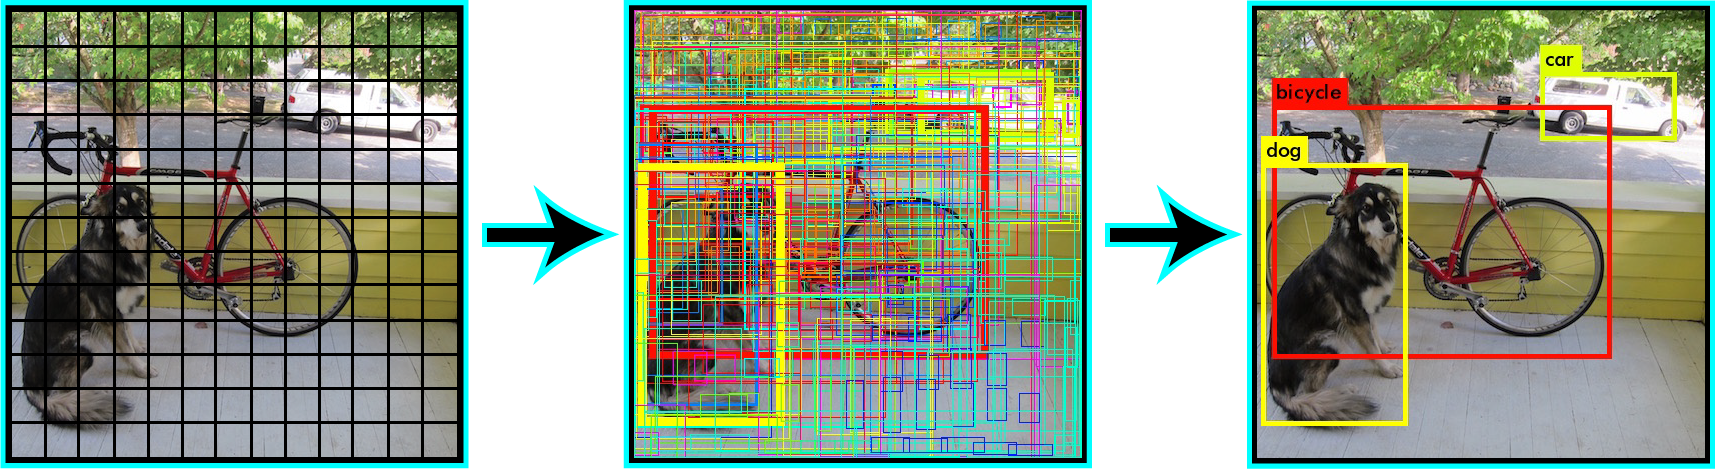


##### 4.1.3 YOLOv5 Model Architecture
YOLO network architecture consists of three parts, backbone, which will extract unique features from the particular image. Neck, elaborate in feature Pyramid. Then head is responsible for generating the result, the graph with bounding boxes, confidence score and object classification.

In YOLOv5, it uses CSPDarknet as its backbone, which is a CNN  that adopts cross stage partial structure. It partitions the feature map of the layer into two parts and merges them through a cross-stage hierarchy. By split and merge strategy it optimises duplicate gradient information while maintaining accuracy. Then utilise PANet as its neck, downsampling the extracted feature, obtains a feature map with decreasing size and pixels, it enhances recognition ability and performs better detection and helps detect objects in all scales. Then head layer for the final output.  

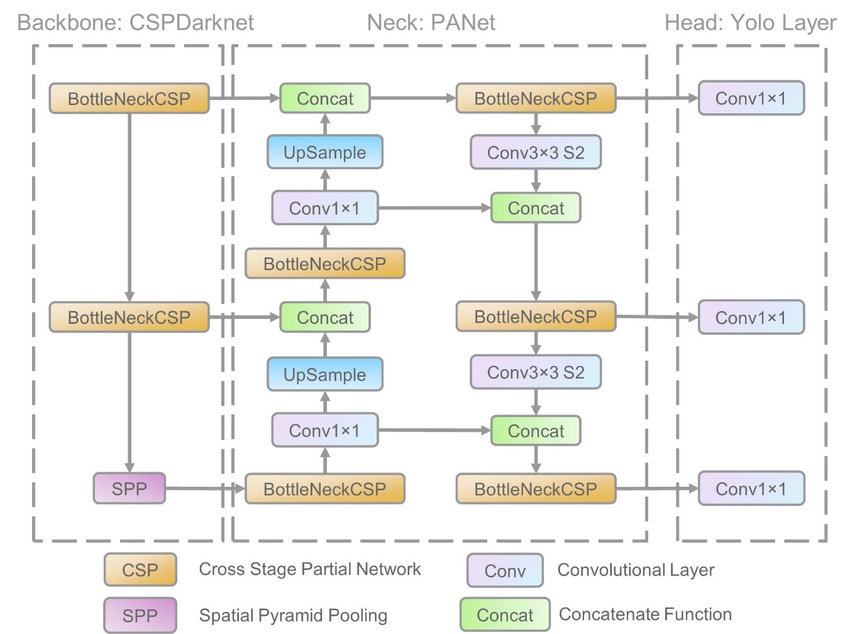

## 4.2 Attention Modules
Attention is an attempt to enhance the important parts while downplaying irrelevant information. In our dataset, we focus on Pedestrian detection, Weakens other non-relevant information, such as traffic signals.




#### 4.2.1 SE
SE net also known as the Squeeze-and-Excitation Networks consists of 3 steps: the Squeeze Module, Excitation Module, and Scale Module. 

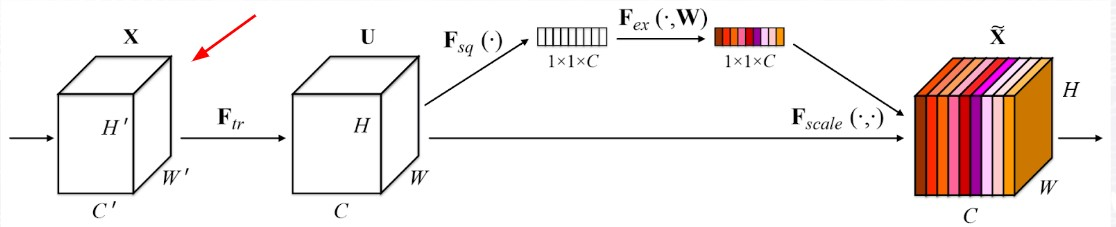

First, the squeeze excitation block takes an input tensor x reduces it to a (C × 1 × 1) tensor through passing the  ( Global Average Pool) layer.

Next is the Excitation module. The output (C×1×1) tensor from the last section is passed to a c-length vector layer and outputs a tensor of same length that is then broadcasted and multiplied lament-wise with the input x.

SE is a well renowned attention mechanism and adding it in front of the SPPP layer in the yolov5 backbone as suggested by the author, could increase performance. 

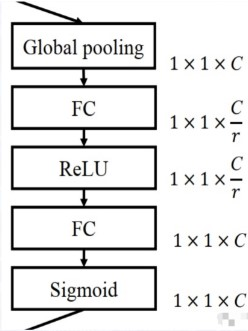

In [41]:
import torch.nn as nn
import torch

# this is for SE attention module
class SE(nn.Module):
    """
    Reference: [Squeeze-and-Excitation Networks]
    Links: https://arxiv.org/pdf/1709.01507.pdf
           https://blog.csdn.net/weixin_43694096/article/details/124443059
    """
    def init(self, c1, c2, ratio=16):
        super(SE, self).init()
        #c11
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.l1 = nn.Linear(c1, c1 // ratio, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.l2 = nn.Linear(c1 // ratio, c1, bias=False)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        b, c, __,  = x.size()
        y = self.avgpool(x).view(b, c)
        y = self.l1(y)
        y = self.relu(y)
        y = self.l2(y)
        y = self.sig(y)
        y = y.view(b, c, 1, 1)
        return x * y.expand_as(x)

#### 4.2.2 SPD
From the diagram, we can see that the SPD-Conv net consists of two components: a  space to depth layer followed by a non-strided convolution layer. 

The SPD layer downsamples a feature map X but retains all the information in the channel dimension, and thus there is no information loss. 

The non-strided convolution operation after each SPD to reduce the (increased) number of channels using learnable parameters in the added convolution layer.

We have chosen SPD attention module because the spd paper noted that it improves performance of images with low resolutions of size 640 x 640 and this fits with our dataset.

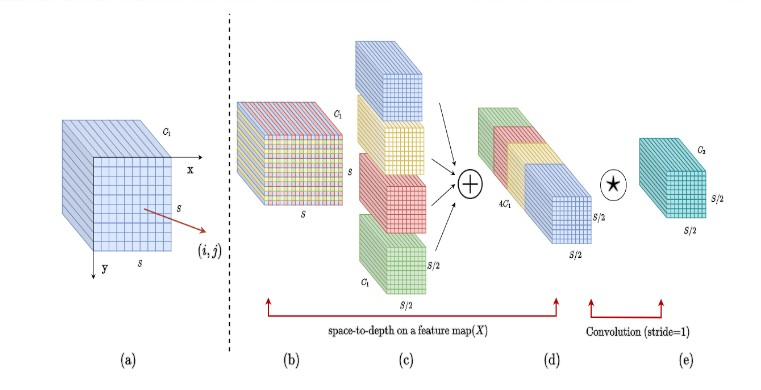


In [42]:
# this is for SPD attention module
class space_to_depth(nn.Module):
    """
    Reference: [https://arxiv.org/abs/2208.03641v1]
    Links: https://arxiv.org/abs/2208.03641v1
            https://github.com/labsaint/spd-conv
            https://yolov5.blog.csdn.net/article/details/126398068?spm=1001.2014.3001.5502
    """
    # Changing the dimension of the Tensor
    def init(self, dimension=1):
        super().init()
        self.d = dimension

    def forward(self, x):
            return torch.cat([x[..., ::2, ::2], x[..., 1::2, ::2], x[..., ::2, 1::2], x[..., 1::2, 1::2]], 1)


#### 4.2.3 ECA
The ECA net is similar to the SE-Net.The ECA-block uses the same global feature descriptor as the SEnet explained previously where it was named the squeeze module and the tensor is decomposed to a channel vector. 
After this, the channel vector passes through a global average pooling layer and is followed by a 1D convolutional layer with an adaptive neighbourhood interaction of kernel size k. 
After this, the result is does the same as the Se-net and is broadcasted and does element wise multiplication with the input tensor.

The ECA attention module was chosen by us as the paper author has stated it performs better than the SE-net and is added to the yolov5 in the same position as the SeNet for comparison.

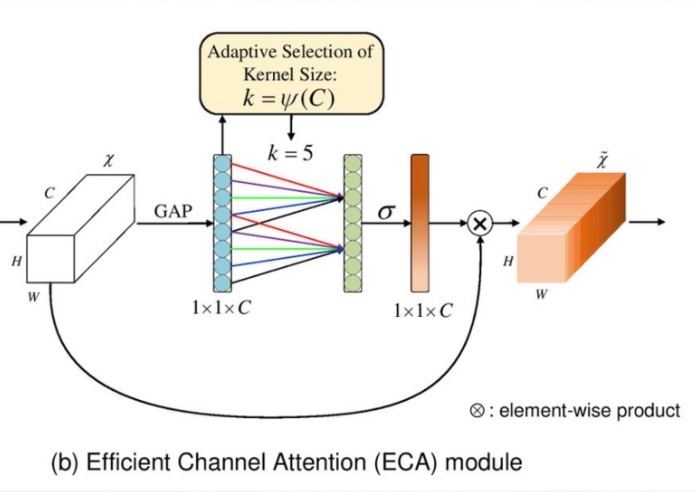


In [38]:
# this is for ECA attention module
class ECA(nn.Module):
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """

    def init(self, c1,c2, k_size=3):
        super(ECA, self).init()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # print(y.shape,y.squeeze(-1).shape,y.squeeze(-1).transpose(-1, -2).shape)
        # Two different branches of ECA module
        # 50C11
        #50C1
        #501C
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x , y.expand_as(x)

#### 4.2.4 Mobile Net
MobilenetV3 is mainly added to our experiment as a comparison with the basic yolov5 to see if it can speed up training.

What we did is changing the whole backbone of the yolov5. When comparing with YOLOv5, mobilenet use depthwise separable convolution to reduce the number of weight. So, theoriticly it will reducethe  training time.

MobilenetV3 the updated version of mobilenet family. For version 1, it used depthwise separable convolution, and used two hyper-parameters to trade off between latency and accuracy. In version 2, it added inverted residual and shortcut to improve the accuracy.As for the updated version 3, it added the SE attention mechanism which we have introduced before and replace the swish activate function with h-swish function. 

These changes improve the overall performance of Mobilenet. Meanwhile, mobilenet is runable in small devices with limited computation units.
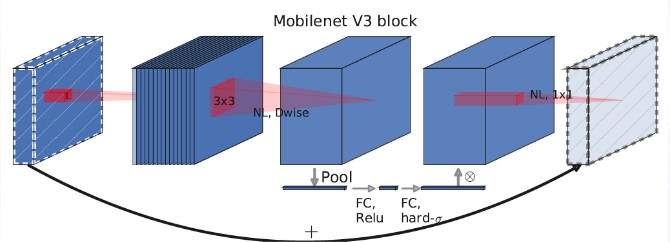

In [40]:
# Following are mobilenetv3 part
class h_sigmoid(nn.Module):
  """
  Reference: [Searching for MobileNetV3]
  Links: https://arxiv.org/pdf/1905.02244.pdf
         https://blog.csdn.net/weixin_44808161/article/details/125759652
  """
  def __init__(self, inplace=True):
      super(h_sigmoid, self).__init__()
      self.relu = nn.ReLU6(inplace=inplace)

  def forward(self, x):
      return self.relu(x + 3) / 6
 
 
class h_swish(nn.Module):
  def __init__(self, inplace=True):
      super(h_swish, self).__init__()
      self.sigmoid = h_sigmoid(inplace=inplace)

  def forward(self, x):
      return x * self.sigmoid(x)
 
 
class SELayer(nn.Module):
  def __init__(self, channel, reduction=4):
      super(SELayer, self).__init__()
      # Squeeze
      self.avg_pool = nn.AdaptiveAvgPool2d(1)
      # Excitation(FC+ReLU+FC+Sigmoid)
      self.fc = nn.Sequential(
          nn.Linear(channel, channel // reduction),
          nn.ReLU(inplace=True),
          nn.Linear(channel // reduction, channel),
          h_sigmoid()
      )

  def forward(self, x):
      b, c, _, _ = x.size()
      y = self.avg_pool(x)
      y = y.view(b, c)
      y = self.fc(y).view(b, c, 1, 1) 
      return x * y
 
 
class conv_bn_hswish(nn.Module):
    """
    This equals to
    def conv_3x3_bn(inp, oup, stride):
        return nn.Sequential(
            nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
            nn.BatchNorm2d(oup),
            h_swish()
        )
    """
    def __init__(self, c1, c2, stride):
      super(conv_bn_hswish, self).__init__()
      self.conv = nn.Conv2d(c1, c2, 3, stride, 1, bias=False)
      self.bn = nn.BatchNorm2d(c2)
      self.act = h_swish()

    def forward(self, x):
      return self.act(self.bn(self.conv(x)))

    def fuseforward(self, x):
      return self.act(self.conv(x))
 
 
class MobileNet_Block(nn.Module):
  def __init__(self, inp, oup, hidden_dim, kernel_size, stride, use_se, use_hs):
      super(MobileNet_Block, self).__init__()
      assert stride in [1, 2]

      self.identity = stride == 1 and inp == oup

      if inp == hidden_dim:
          self.conv = nn.Sequential(
              # dw
              nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim,
                        bias=False),
              nn.BatchNorm2d(hidden_dim),
              h_swish() if use_hs else nn.ReLU(inplace=True),
              # Squeeze-and-Excite
              SELayer(hidden_dim) if use_se else nn.Sequential(),
              # pw-linear
              nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
              nn.BatchNorm2d(oup),
          )
      else:
          
          self.conv = nn.Sequential(
              # pw
              nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
              nn.BatchNorm2d(hidden_dim),
              h_swish() if use_hs else nn.ReLU(inplace=True),
              # dw
              nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim,
                        bias=False),
              nn.BatchNorm2d(hidden_dim),
              # Squeeze-and-Excite
              SELayer(hidden_dim) if use_se else nn.Sequential(),
              h_swish() if use_hs else nn.ReLU(inplace=True),
              # pw-linear
              nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
              nn.BatchNorm2d(oup),
          )

  def forward(self, x):
      y = self.conv(x)
      if self.identity:
          return x + y
      else:
          return

## 5.0 Results

In [2]:
!pip install clearml > dev/null 2

The system cannot find the path specified.


### 5.1 Before Data augmentation
From the chart shown, before data augmentation is applied, the yolov5 outperforms all attention mechanisms models implemented and the MobileV3 net selected for comparison. 


### 5.2 Before Data augmentation
After applying mosaic data augmentation technique to our dataset, the SPD attention module outperforms the vanilla yolov5 model and all other models. 
There is also an overall 30% increase in performance for all models that are trained.

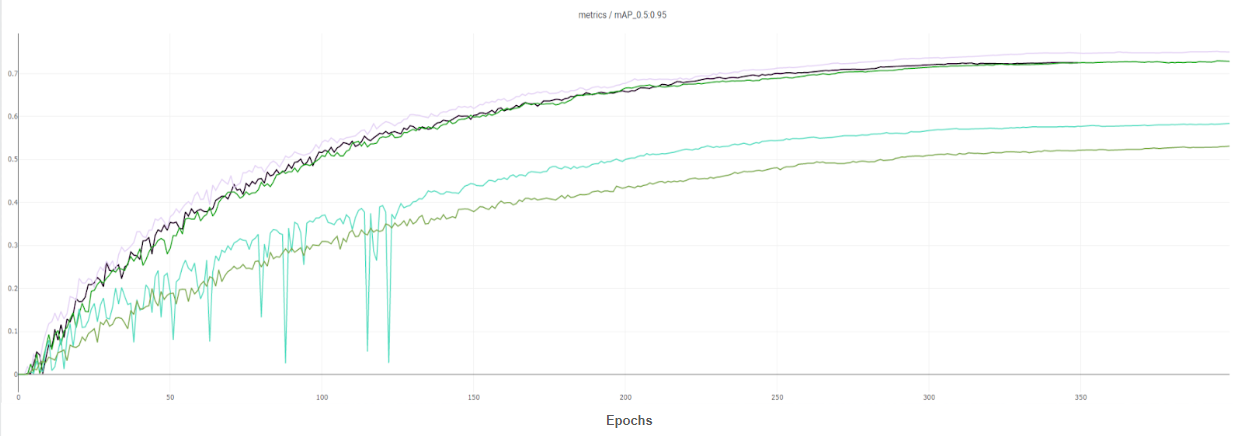


## 6.0 Discussion
### 6.1 Before Data Augmentation
Before data augmentation, the SE-net and ECA-net and other attention modules consistently performed worse than yolov5’s base model. This is because these modules make yolov5's backbone undergo global average pooling twice; once in the added attention mechanism; another time in the SPPP section of the yolov5 backbone. 
This causes there to be two pooling functions and further loss of distinct characteristics of small sized pedestrians in images and as a result, means lower performance. 


#### 6.2 After Data Augmentation
As mentioned before, mosaic data augmentation generates an extra image that is merged from 1 original image + 3 random images. Due to this reason, our dataset doubled in size and improved detection of smaller-sized pedestrians in bounding boxes of grids that yolov5 creates.



### 6.3 Models
#### 6.3.1 ECA and SE comparison:
The ECA module is an improved methodology for object detestrian than the SEnet. However, the ECAnet performs worse than the SE-net. This is likely because of ECAnet's extra adaptive neighbourhood interaction filtering out the distinct features of small pedestrians in images, hence reducing performance.

#### 6.3.2 SPD
SPD has better performance in every epoch than all other models. This is because SPD uses a self-made space-to-depth layer such that information from previous layers will be preserved in low-resolution images, hence fits our dataset perfectly.

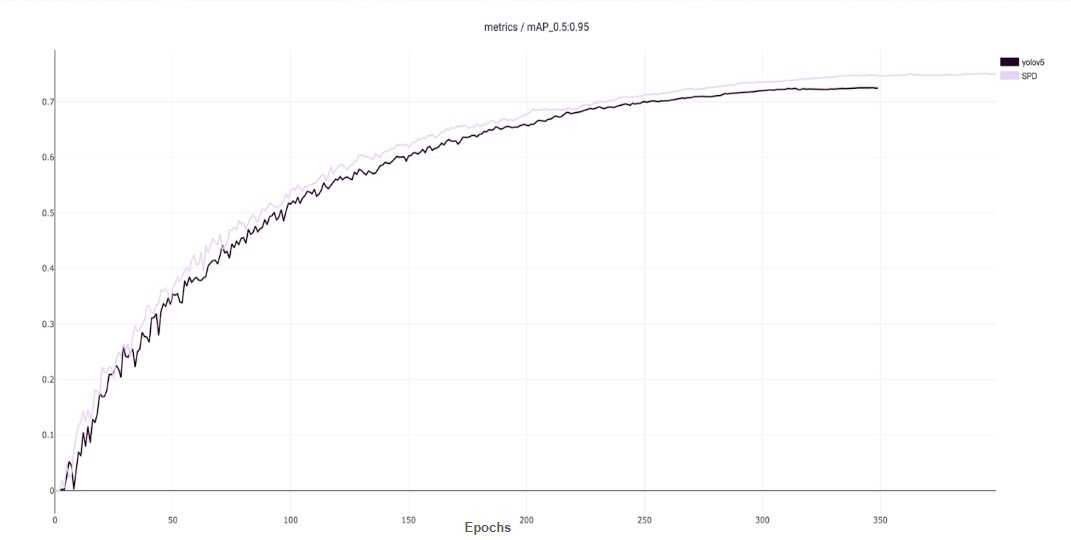

#### 6.3.3 MobileNet V3
Mobilenet is a light model with very short training time, however, it consistently performs the worst out of all other models. This is due to the h-swish function having reduced amounts of calculations to make it faster.


## 7.0 Conclusion
From the experiment, we have discovered that SPD and Mobilenet are able to enhance the performance of YOLOv5l,  regarding on the speed and accuracy. If the power of computation is sufficient, Mobilenet could be a better choice, if there’s no worry about the computation resources at all, we can use the SPD to get better accuracy. 